# Create Binary Mask from PNG

by _Tobias Reaper_

The goal of this notebook is to write a script that programmatically creates binary masks (white / black) from a PNGs files with transparent backgrounds.
These masks will be used to generate COCO-formatted datasets, which will in turn be used to train a Detectron2 object detection model.

Resources:

- [Image segmentation using color spaces in opencv + python](https://realpython.com/python-opencv-color-spaces/)
- [Object detection via color-based image segmentation using python](https://towardsdatascience.com/object-detection-via-color-based-image-segmentation-using-python-e9b7c72f0e11)

Note:

> Although the images used in the notebooks in this repo is not huge, it is large enough that it is not included in this shared repository. The dataset before and after the conversion into the mask / COCO format is available at [tobias-fyi/neurecycle](https://github.com/tobias-fyi/neurecycle/tree/master/pycoco)

---

In [13]:
# === Imports === #
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

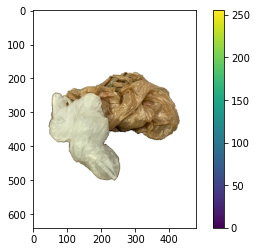

In [5]:
# === Load and view image === #
img1 = cv2.imread("test_images/001-clear.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.colorbar()
plt.show()

In [6]:
# Use GrabCut to create mask
mask = np.zeros(img1.shape[:2], np.uint8)

# === Set up bg and fg models === #
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)

# Define the rectangle with x, y, width, height
# In this case, the entire image
rect = (
    img1.shape[0] // 20,
    img1.shape[0] // 20,
    img1.shape[0] - 10,
    img1.shape[1] - 10
)

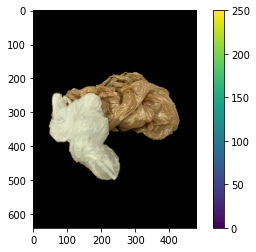

In [7]:
# === Make the cut and grab that ish!~ === #
cv2.grabCut(img1, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1_masked = img1 * mask[:, :, np.newaxis]

plt.imshow(img1_masked)
plt.colorbar()
plt.show()

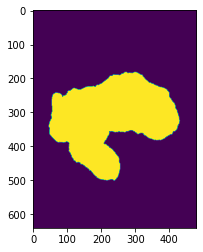

In [8]:
# === Take a look at the mask === #
plt.imshow(mask)
plt.show()

In [12]:
# === Save mask using matplotlib === #
plt.imsave("mask1.png", mask)

In [22]:
# === Write the above code into a function === #

def png_to_mask(path_to_img, filename):
    """Creates a binary mask from a transparent PNG."""

    # Load image
    img = cv2.imread(path_to_img)

    # Create blank mask of zeros
    mask = np.zeros(img.shape[:2], np.uint8)

    # Set up bg and fg models
    bg = np.zeros((1, 65), np.float64)
    fg = np.zeros((1, 65), np.float64)

    # Define the rectangle - hardcoded to use entire image
    rect = (
        img.shape[0] // 20,
        img.shape[0] // 20,
        img.shape[0] - 10,
        img.shape[1] - 10
    )

    # Make the cut and grabby grabby the mask
    cv2.grabCut(img, mask, rect, bg, fg, 5, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')

    # Save mask to file
    plt.imsave(filename, mask)

In [29]:
# === Test out the png_to_mask() function === #
test_img_old_path = "/Users/Tobias/workshop/buildbox/neurecycle/notebooks/test_images/metal_can_021.png"
test_img_new_path = "/Users/Tobias/workshop/buildbox/neurecycle/notebooks/test_images/metal_can_021_mask.png"

png_to_mask(test_img_old_path, test_img_new_path)

In [34]:
# === Walk manually to have more control over renaming/moving === #

# Dir with backgrounds; image
items_dir = "/Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/items_train2019"
back = "/Users/Tobias/workshop/buildbox/neurecycle/pycoco/back"

# Dir without backgrounds; mask
ann_dir = "/Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/annotations"
fore = "/Users/Tobias/workshop/buildbox/neurecycle/pycoco/fore"

# Ex filenames:
# annotation - 0087_metal_cans_0087.png
# image      - 0087.jpeg

id_counter = 0

# Loop through all class directories
for subdir in os.listdir(fore):
    os.chdir(fore)  # Move (back) to root
    os.chdir(subdir)  # Move to working dir
    print(os.getcwd())
    for f in os.listdir():
        id_counter += 1
        f_name, f_ext = os.path.splitext(f)

        # The subdir is the item_class_name
        item_class_name = subdir
        img_ann_id = str(id_counter).zfill(4)

        # Move (rename) back/subdir/f -> items/train/items_train2019/f_img_name
        f_img_name = f"{img_ann_id}{f_ext}"
        f_old_img_path = os.path.join(back, subdir, f)
        f_new_img_path = os.path.join(items_dir, f_img_name)
        os.rename(f_old_img_path, f_new_img_path)

        # Visual confirmation
        print(f"{f_old_img_path}")
        print(f"-> {f_new_img_path}")

        # Create mask and save to new location
        # fore/subdir/f -> items/train/annotations
        f_anno_name = f"{img_ann_id}_{item_class_name}_{img_ann_id}{f_ext}"
        f_old_anno_path = os.path.join(fore, subdir, f)
        f_new_anno_path = os.path.join(ann_dir, f_anno_name)
        png_to_mask(f_old_anno_path, f_new_anno_path)

        os.remove(f_old_anno_path)  # Remove the original foreground file

        # Visual confirmation
        print(f"{f_old_anno_path}")
        print(f"-> {f_new_anno_path}")

cle/pycoco/items/train/annotations/0418_plastic_container_food_0418.png
/Users/Tobias/workshop/buildbox/neurecycle/pycoco/back/plastic_container_food/063.png
-> /Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/items_train2019/0419.png
/Users/Tobias/workshop/buildbox/neurecycle/pycoco/fore/plastic_container_food/063.png
-> /Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/annotations/0419_plastic_container_food_0419.png
/Users/Tobias/workshop/buildbox/neurecycle/pycoco/back/plastic_container_food/077.png
-> /Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/items_train2019/0420.png
/Users/Tobias/workshop/buildbox/neurecycle/pycoco/fore/plastic_container_food/077.png
-> /Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/annotations/0420_plastic_container_food_0420.png
/Users/Tobias/workshop/buildbox/neurecycle/pycoco/back/plastic_container_food/073.png
-> /Users/Tobias/workshop/buildbox/neurecycle/pycoco/items/train/items_train2019/0421.png
